In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator

sns.set_theme(style="white", font_scale=1.5)

baseline_data = pd.read_csv("../questionnaire/baseline.csv")
baseline_data["Group"] = "Baseline"
experiment_data = pd.read_csv("../questionnaire/experiment.csv")
experiment_data["Group"] = "FARPLS"
mann_whitney_u_test = pd.read_csv("../result/mann_whitney_u_test.csv", index_col=0)
t_test = pd.read_csv("../result/t-test.csv", index_col=0)

In [2]:
METRIC_COLUMNS = [
    "Consistency",
    "Total Time",
]

LIKERT_COLUMNS = [
    "Cognitive Load",
    "Confidence",
    "C1",
    "C1.1",
    "C1.2",
    "C1.3",
    "C2",
    "C2.1",
    "C2.2",
    "C2.3",
    "C3.1",
    "C3.2",
    "C3.3",
    "C3.4",
    "C3.5",
]

C1 = [
    "C1",
    "C1.1",
    "C1.2",
    "C1.3",
]
C1_MAP = {
    "C1": "C1\n[criteria establishment]",
    "C1.1": "C1-1\n[criteria coverage]",
    "C1.2": "C1-2\n[feature coverage]",
    "C1.3": "C1-3\n[feature distribution]",
}

C2 = [
    "C2",
    "C2.1",
    "C2.2",
    "C2.3",
]
C2_MAP = {
    "C2": "C2\n[detail overlooking]",
    "C2.1": "C2-1\n[robotic knowledge]",
    "C2.2": "C2-2\n[feature support]",
    "C2.3": "C2-3\n[comparison support]",
}

C3 = [
    "C3.1",
    "C3.2",
    "C3.3",
    "C3.4",
    "C3.5",
]
C3_MAP = {
    "C3.1": "C3-1\n[easy]",
    "C3.2": "C3-2\n[boring]",
    "C3.3": "C3-3\n[encouragement]",
    "C3.4": "C3-4\n[feedback]",
    "C3.5": "C3-5\n[rewarding]",
}


QUALTRICS_ADDITIONAL_COLUMNS = [
    "informative",
    "relevant",
    "criteria",
    "details",
    "comparing",
    "overwhelming",
    "distracting",
    "DR1C1.1",
    "DR1C2.2",
    "DR2C1.2",
    "DR2C2",
    "DR3C3.1",
    "DR3C3.5",
]
QUALTRICS_ADDITIONAL_COLUMNS_MAP = {
    "informative": "AX1\n[informative]",
    "relevant": "AX2\n[relevant]",
    "criteria": "AX3\n[criteria]",
    "details": "AX4\n[details]",
    "comparing": "AX5\n[comparing]",
    "overwhelming": "AX6\n[overwhelming]",
    "distracting": "AX7\n[distracting]",
    "DR1C1.1": "DR1C1-1\n[initial familiarity]",
    "DR1C2.2": "DR1C2-2\n[detail aware]",
    "DR2C1.2": "DR2C1-2\n[criteria priority]",
    "DR2C2": "DR2C2\n[sense making]",
    "DR3C3.1": "DR3C3-2\n[↓ boredom]",
    "DR3C3.5": "DR3C3-5\n[↑ reward]",
}

In [3]:
def get_annotation_text(p_value, alternative):
    # 格式化p值
    scientific_notation = "{:.4f}".format(p_value)

    if alternative == "two-sided":
        alternative = "different"
    elif alternative == "less":
        alternative = ">"
    else:
        alternative = "<"

    if p_value < 0.05:
        if p_value < 0.01:
            if p_value < 0.001:
                p_realm = "*** < 0.001"
            else:
                p_realm = "** < 0.01"
        else:
            p_realm = "* < 0.05"
        significance = "significantly"
    else:
        p_realm = " > 0.05"
        significance = "no significance"
        alternative = ""

    # 根据显著性判断设置标注信息
    text = f"p = {scientific_notation}{p_realm}\n{significance} {alternative}"
    return text

In [4]:
def plot_box_with_significance(column_names, test_type, title, column_label_map=None):
    sns.set_theme(style="white", font_scale=1.4)
    list_df = []
    for column_name in column_names:
        data = pd.melt(
            pd.concat([baseline_data, experiment_data]),
            id_vars=["Group"],
            value_vars=column_name,
            var_name="Metric",
            value_name="Value",
        )
        list_df.append(data)
    df = pd.concat(list_df)
    if np.all([column_name in LIKERT_COLUMNS for column_name in column_names]):
        df["Value"] = df["Value"].astype(int)
    else:
        df["Value"] = df["Value"].astype(float)

    plt.figure(figsize=(4 + 2 * len(column_names), 5.5 + 0.5 * len(column_names)))
    # 绘制箱线图
    color = sns.color_palette("RdYlBu", 13)[2:13:9]
    if len(column_names) == 1:
        ax = sns.boxplot(
            data=df,
            x="Group",
            y="Value",
            palette=color,
            width=0.3,
            showmeans=True,
            meanprops={
                "marker": "x",
                "markeredgecolor": "black",
                "markersize": "9",
            },
            medianprops={"color": "black", "linewidth": "2", "linestyle": "--"},
        )
        ax.set_xlabel("")
    elif len(column_names) == 2:
        ax = sns.boxplot(
            data=df,
            x="Metric",
            y="Value",
            hue="Group",
            palette=color,
            width=0.4,
            showmeans=True,
            meanprops={
                "marker": "x",
                "markeredgecolor": "black",
                "markersize": "10",
            },
            medianprops={"color": "black", "linewidth": "2", "linestyle": "--"},
        )
        ax.set_xlabel("")
        ax.set_ylim(0, 8)
        ax.set_yticks(np.arange(1, 8, 1))
    else:
        ax = sns.boxplot(
            data=df,
            x="Metric",
            y="Value",
            hue="Group",
            palette=color,
            width=0.5,
            showmeans=True,
            meanprops={
                "marker": "x",
                "markeredgecolor": "black",
                "markersize": "12",
            },
            medianprops={"color": "black", "linewidth": "2", "linestyle": "--"},
        )
        ax.set_xlabel("")
        ax.set_ylim(0, 8)
        ax.set_yticks(np.arange(1, 8, 1))
    if np.all([column_name in LIKERT_COLUMNS for column_name in column_names]):
        ax.set_ylabel("7-point Likert-scale Score")
        if column_label_map:
            ax.set_xticklabels([column_label_map[metric] for metric in column_names])
    elif "Consistency" in column_names:
        ax.set_ylabel("Consistency")
        min_value = df["Value"].min()
        max_value = df["Value"].max()
        ax.set_yticks(np.arange(int(min_value*10)/10.0, int(max_value*10)/10.0 + 0.1, 0.1))
    elif "Total Time" in column_names:
        ax.set_ylabel("Total Time (s)")
    else:
        ax.set_ylabel("")

    # 使用 statannotations 库来标注显著性
    if len(column_names) == 1:
        pairs = [("Baseline", "FARPLS")]
        annotator = Annotator(ax, pairs=pairs, data=df, x="Group", y="Value")
    else:
        pairs = [
            ((column_name, "Baseline"), (column_name, "FARPLS"))
            for column_name in column_names
        ]
        annotator = Annotator(
            ax, pairs=pairs, data=df, x="Metric", y="Value", hue="Group"
        )
    annotator.configure(test=None, verbose=2, fontsize=15, text_offset=2)

    annotation_texts = []
    if test_type == "Mann-Whitney U Test":
        for column_name in column_names:
            if column_name + "_two_sided" in t_test.index:
                column_name = column_name + "_two_sided"
            p_value = mann_whitney_u_test.loc[column_name, "p-val"]
            alternative = mann_whitney_u_test.loc[column_name, "alternative"]
            annotation_text = get_annotation_text(p_value, alternative)
            annotation_texts.append(annotation_text)
    else:
        for column_name in column_names:
            if column_name + "_reverse" in mann_whitney_u_test.index:
                column_name = column_name + "_reverse"
            p_value = t_test.loc[column_name, "p-val"]
            alternative = t_test.loc[column_name, "alternative"]
            annotation_text = get_annotation_text(p_value, alternative)
            annotation_texts.append(annotation_text)

    annotator.set_custom_annotations(annotation_texts)
    annotator.annotate()

    # # 去除图的上边框和右边框
    # ax.spines['top'].set_visible(False)
    # ax.spines['right'].set_visible(False)
    # plt.gca().spines['top'].set_visible(False)
    # plt.gca().spines['right'].set_visible(False)

    if len(column_names) > 1:
        ax.legend(loc="lower center", ncol=2)

    ax.set_title(f"{title} ({test_type})")    
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    # 保存图形为PDF文件
    plt.savefig(f"./fig/boxplot/{title}.pdf", bbox_inches="tight")
    plt.show()
    plt.close()

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Baseline vs. FARPLS: p = 0.0017** < 0.01
significantly <


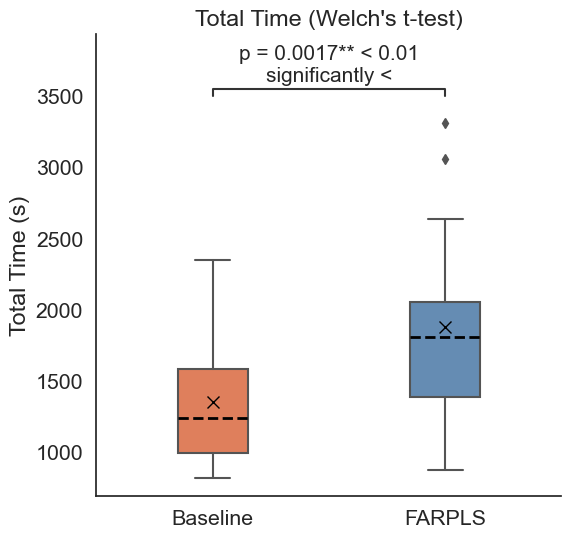

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Baseline vs. FARPLS: p = 0.0046** < 0.01
significantly <


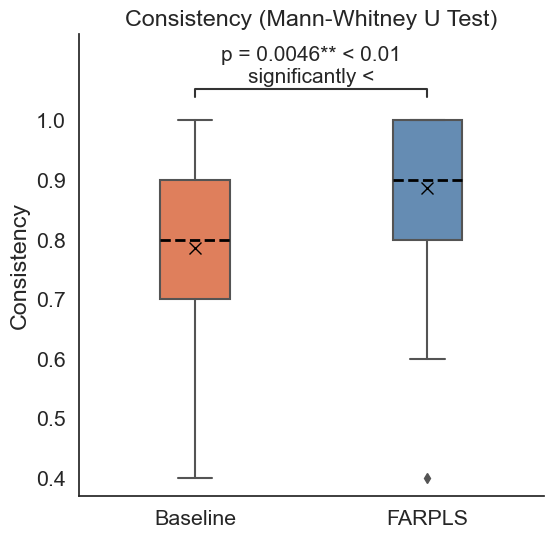

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Confidence_Baseline vs. Confidence_FARPLS: p = 0.2027 > 0.05
no significance 
Cognitive Load_Baseline vs. Cognitive Load_FARPLS: p = 0.4375 > 0.05
no significance 


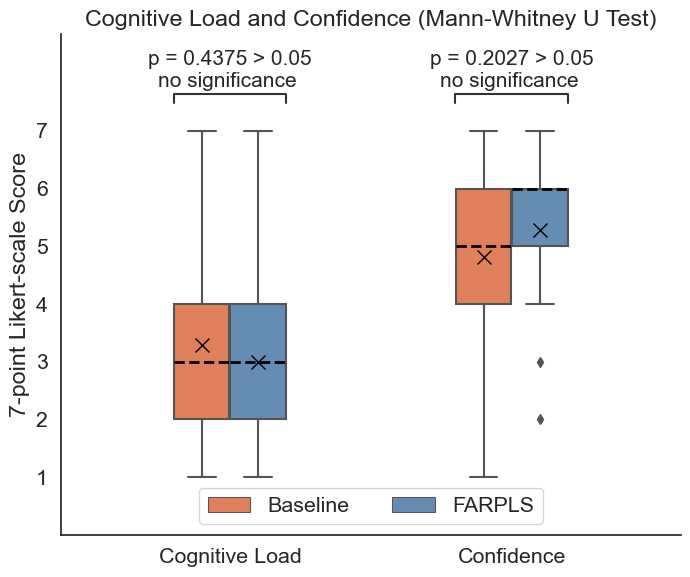

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

C1.1_Baseline vs. C1.1_FARPLS: p = 0.0128* < 0.05
significantly <
C1_Baseline vs. C1_FARPLS: p = 0.0246* < 0.05
significantly <
C1.2_Baseline vs. C1.2_FARPLS: p = 0.1173 > 0.05
no significance 
C1.3_Baseline vs. C1.3_FARPLS: p = 0.1533 > 0.05
no significance 


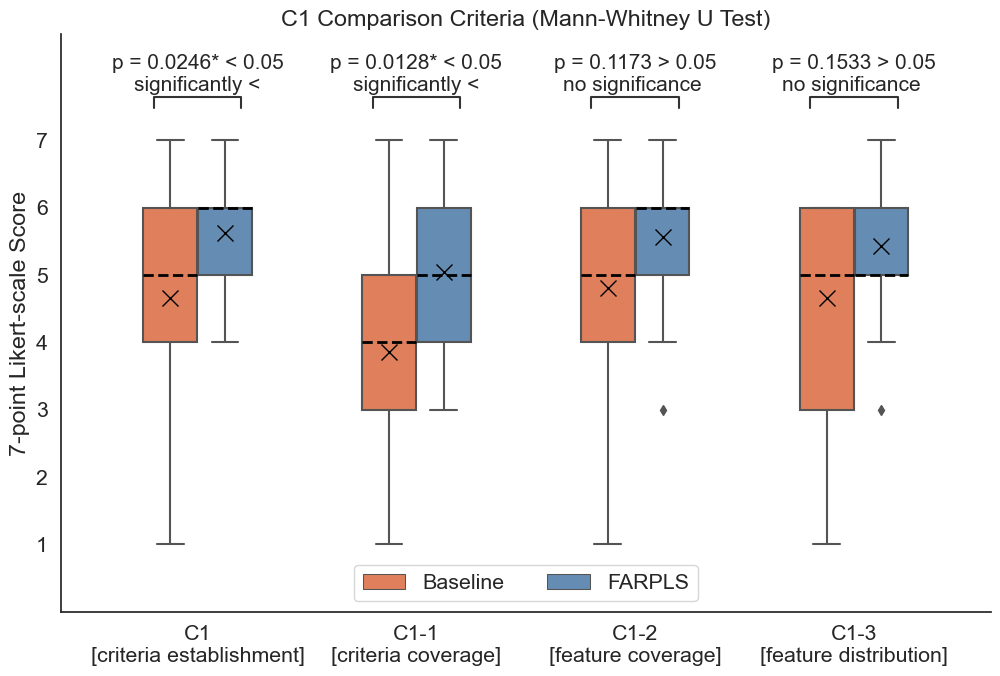

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

C2.1_Baseline vs. C2.1_FARPLS: p = 0.4901 > 0.05
no significance 
C2_Baseline vs. C2_FARPLS: p = 0.8870 > 0.05
no significance 
C2.2_Baseline vs. C2.2_FARPLS: p = 0.0005*** < 0.001
significantly <
C2.3_Baseline vs. C2.3_FARPLS: p = 0.0125* < 0.05
significantly <


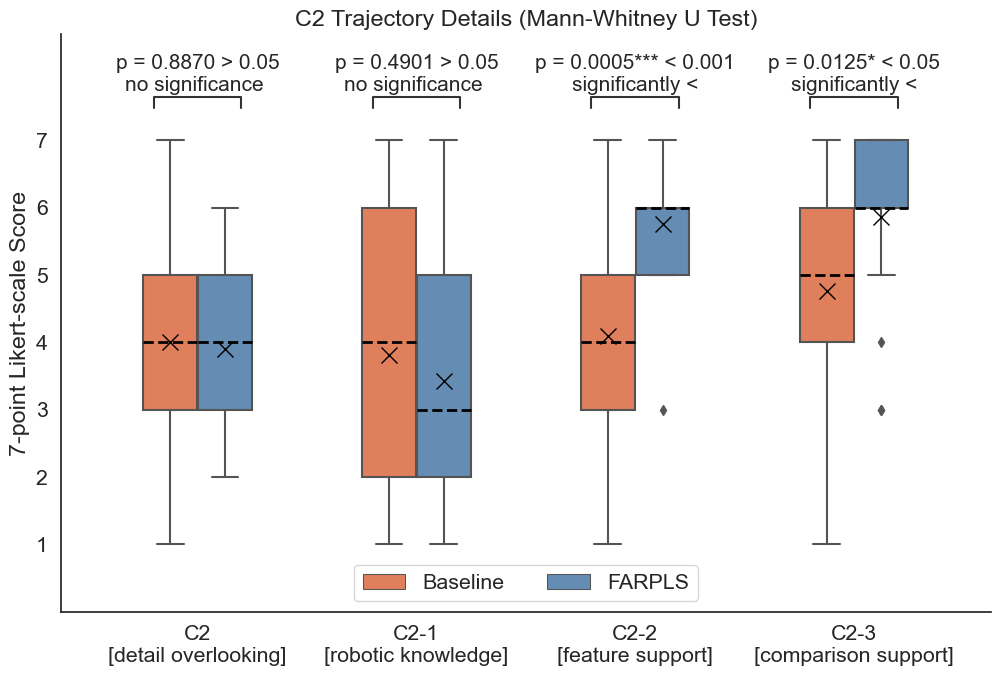

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

C3.2_Baseline vs. C3.2_FARPLS: p = 0.0419* < 0.05
significantly >
C3.1_Baseline vs. C3.1_FARPLS: p = 0.3643 > 0.05
no significance 
C3.3_Baseline vs. C3.3_FARPLS: p = 0.0424* < 0.05
significantly <
C3.4_Baseline vs. C3.4_FARPLS: p = 0.0019** < 0.01
significantly <
C3.5_Baseline vs. C3.5_FARPLS: p = 0.0101* < 0.05
significantly <


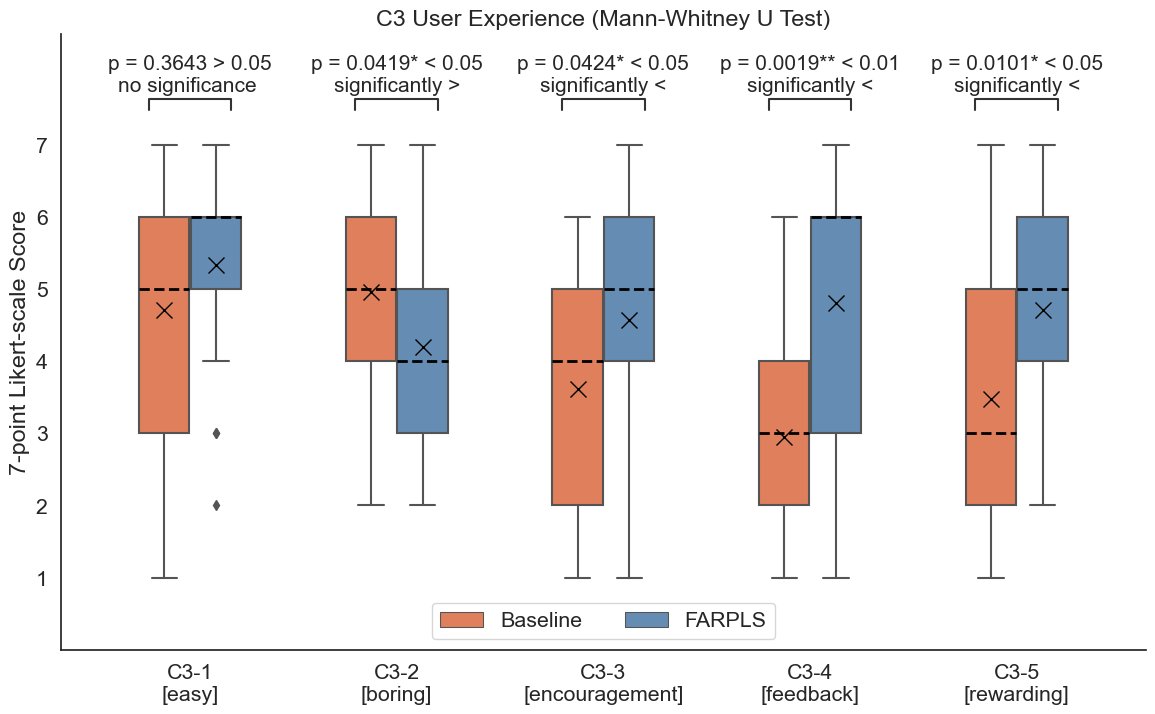

In [5]:
plot_box_with_significance(["Total Time"], "Welch's t-test", "Total Time")
plot_box_with_significance(["Consistency"], "Mann-Whitney U Test", "Consistency")
plot_box_with_significance(
    ["Cognitive Load", "Confidence"],
    "Mann-Whitney U Test",
    "Cognitive Load and Confidence",
)
plot_box_with_significance(C1, "Mann-Whitney U Test", "C1 Comparison Criteria", C1_MAP)
plot_box_with_significance(C2, "Mann-Whitney U Test", "C2 Trajectory Details", C2_MAP)
plot_box_with_significance(C3, "Mann-Whitney U Test", "C3 User Experience", C3_MAP)

In [6]:
def cum_size_until_4(data_counts):
    cum_size = 0
    for value, size in data_counts.items():
        try:
            numeric_value = int(value)
        except ValueError:
            continue
        if numeric_value <= 4:
            cum_size += size

    if 4 in data_counts:
        cum_size -= data_counts[4] / 2
    return cum_size

In [7]:
def plot_stacked_bar_for_column(column_name):
    sns.set_theme(style="white", font_scale=2)
    # 计算每个评分的频率
    baseline_counts = baseline_data[column_name].value_counts().sort_index()
    experiment_counts = experiment_data[column_name].value_counts().sort_index()

    # 创建堆叠条形图
    fig, ax = plt.subplots(figsize=(10, 3.5))  ##A65F21
    colorset_mapping = dict(zip(range(1, 8), sns.color_palette("RdYlBu", 13)[0:14:2]))

    legend_handles = [
        plt.Rectangle((0, 0), 1, 5, facecolor=colorset_mapping[i]) for i in range(1, 8)
    ]
    legend_labels = ["1", "2", "3", "4", "5", "6", "7"]

    # legend_handles = [Line2D([0], [0], color=gray_scale_mapping[i], lw=6, linestyle='-', marker='s', markersize=10, markerfacecolor=gray_scale_mapping[i], markeredgecolor='black') for i in range(1, 8)]
    # 绘制数据
    def plot_data(label, data_counts, position, offset=0):
        cum_size = 0 + offset
        # 定义数字评分级别到文本的映射

        for idx, (value, size) in enumerate(data_counts.items()):
            ax.barh(
                label,
                size,
                left=cum_size,
                height=0.4,
                color=colorset_mapping.get(value, "0.5"),
                linewidth=2.2,
            )
            text_x = cum_size + (size / 2)
            ax.text(
                text_x, position, str(value), ha="center", va="center", color="black"
            )
            cum_size += size

        return cum_size

    cum_baseline = cum_size_until_4(baseline_counts)
    cum_experiment = cum_size_until_4(experiment_counts)
    diff = cum_baseline - cum_experiment
    if diff > 0:
        offset_experiment = diff
        offset_baseline = 0
    else:
        offset_baseline = -diff
        offset_experiment = 0

    cum_size1 = plot_data("Experiment", experiment_counts, 0, offset_experiment)
    cum_size2 = plot_data("Baseline", baseline_counts, 1, offset_baseline)

    # Add legend below the plot, using bbox_to_anchor to move it further down
    ax.legend(
        legend_handles,
        legend_labels,
        title="7-point Likert-scale Score",
        loc="upper center",
        bbox_to_anchor=(0.5, 0),
        ncol=len(legend_labels),
        frameon=False,
    )
    plt.subplots_adjust(bottom=0.3)
    # 在左侧添加标签
    ax.text(-2, 0, "FARPLS", ha="right", va="center", fontweight="bold")
    ax.text(-2, 1, "Baseline", ha="right", va="center", fontweight="bold")
    ax.text(0, 0.5, "Strongly\ndisagree", ha="right", va="center", fontsize=18)
    ax.text(
        max(cum_size1, cum_size2),
        0.5,
        "Strongly\nagree",
        ha="left",
        va="center",
        fontsize=18,
    )

    # 设置图形属性
    ax.set_xlabel("Number of Users")
    # ax.set_title(column_name)
    ax.axis("off")
    ax.axvline(
        cum_baseline + offset_baseline, ymin=0.5, ymax=1, linestyle="--"
    )  # baseline
    ax.axvline(
        cum_experiment + offset_experiment, ymin=0, ymax=0.5, linestyle="--"
    )  # experiment
    pdf_filename = f"./fig/horizontal/{column_name}.pdf"
    fig.savefig(pdf_filename, bbox_inches="tight", format="pdf")
    plt.show()

    plt.close(fig)

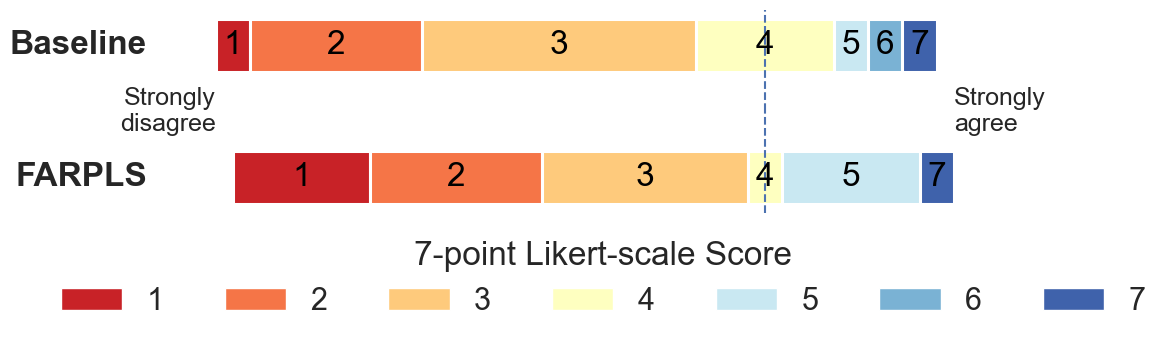

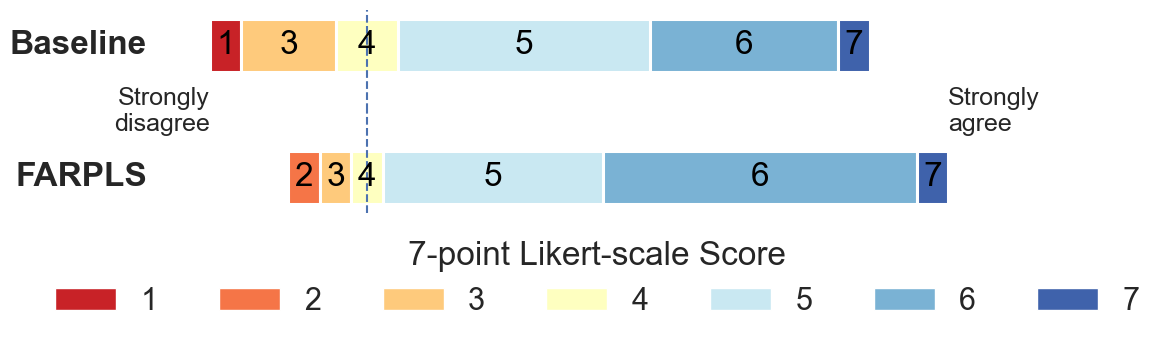

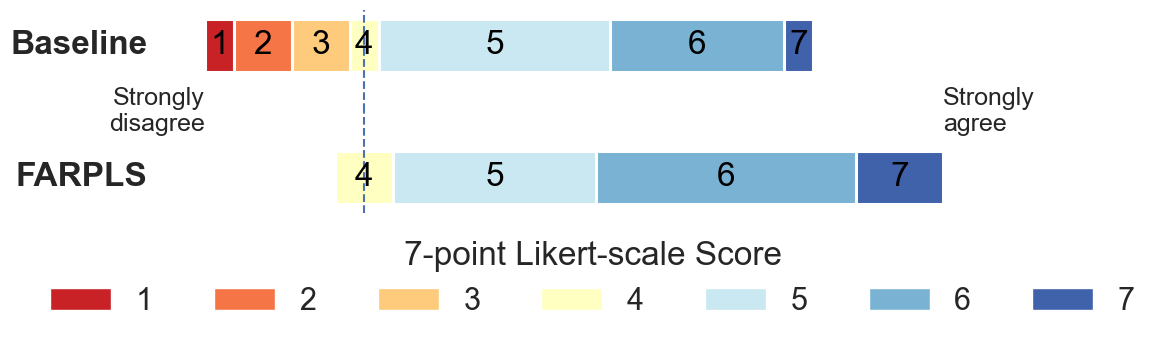

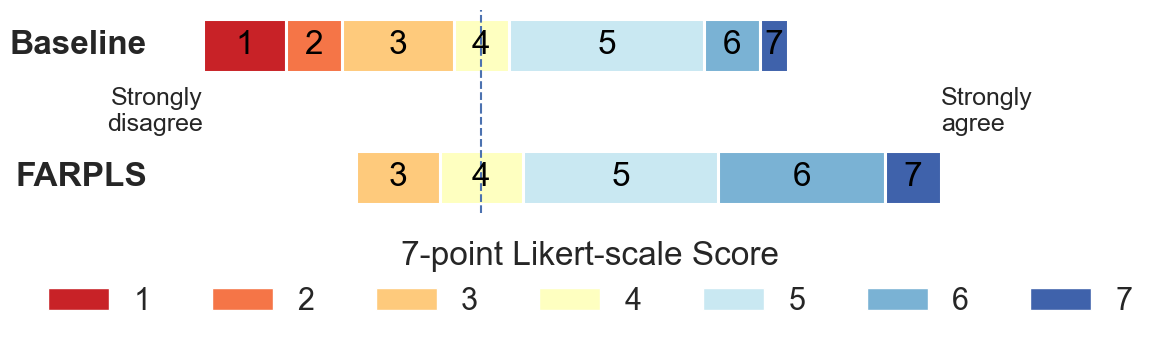

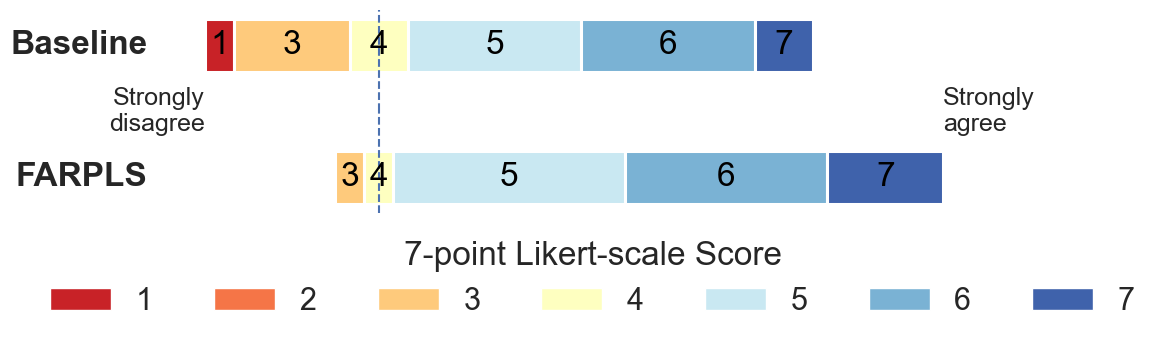

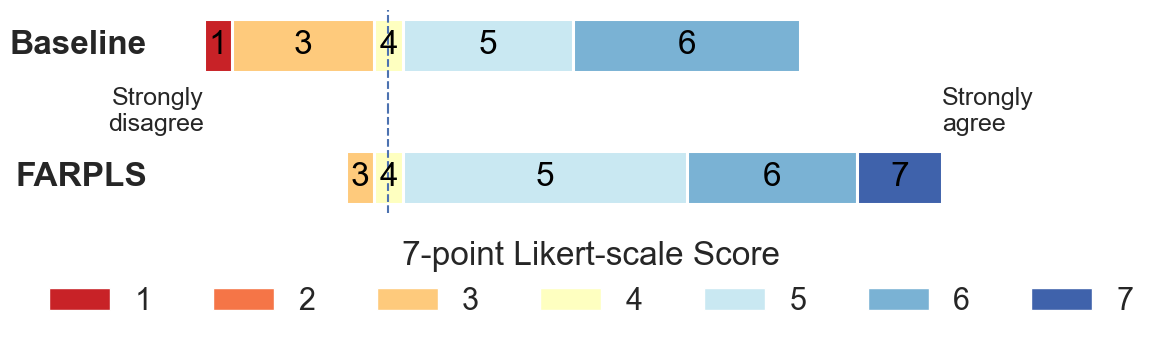

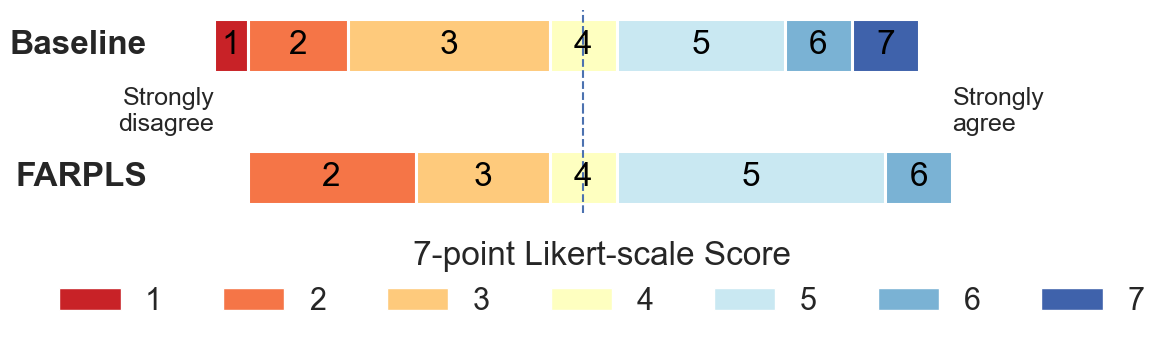

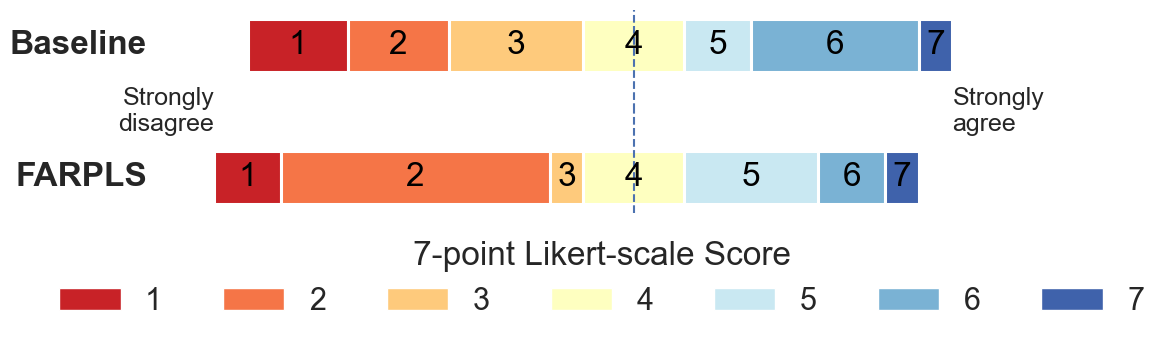

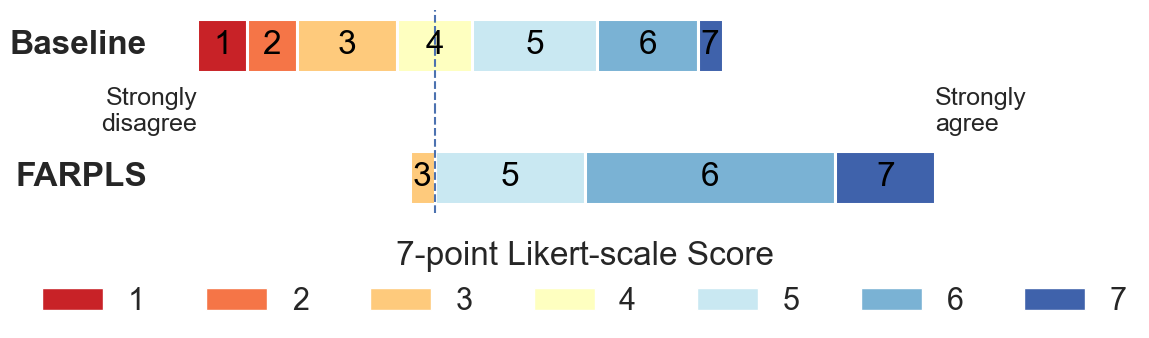

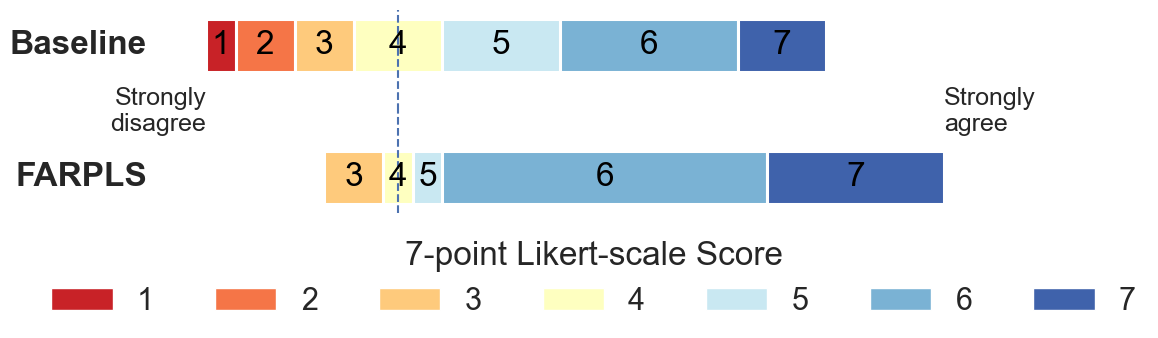

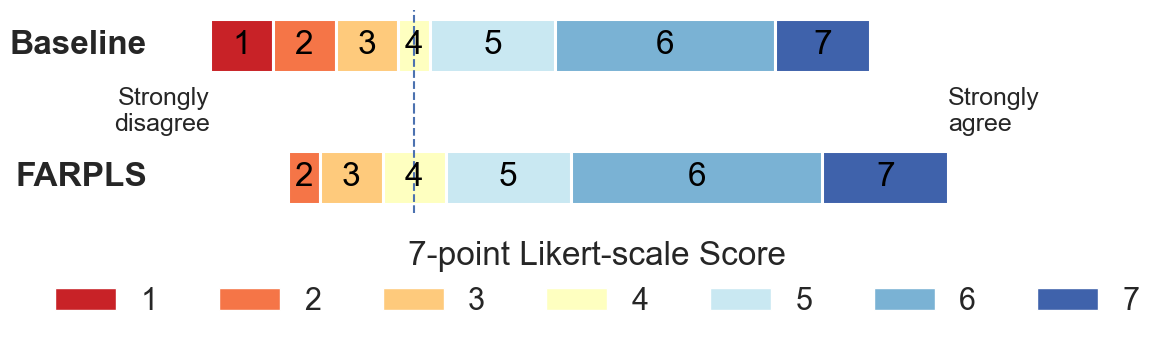

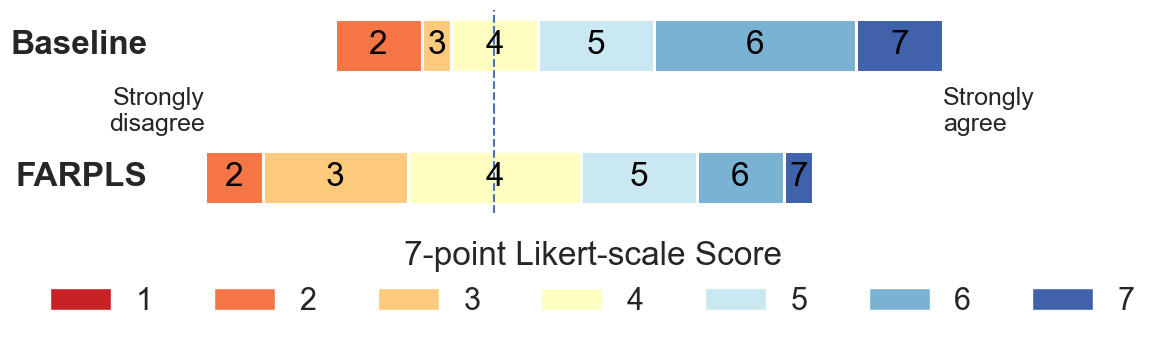

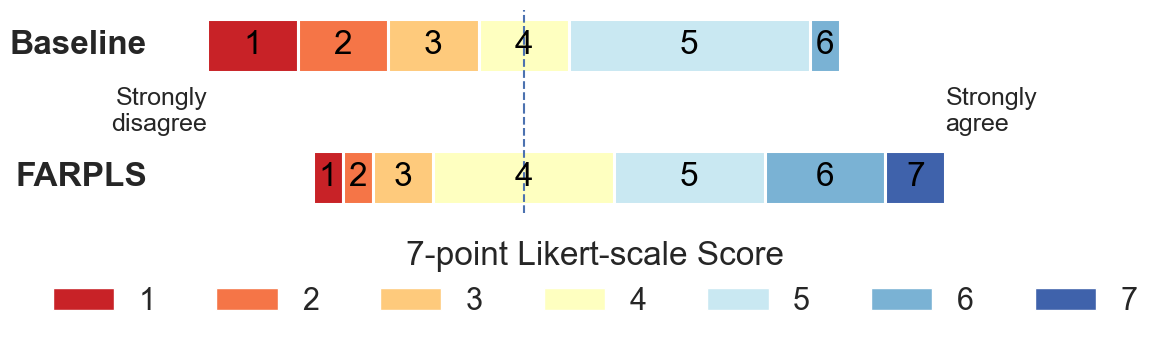

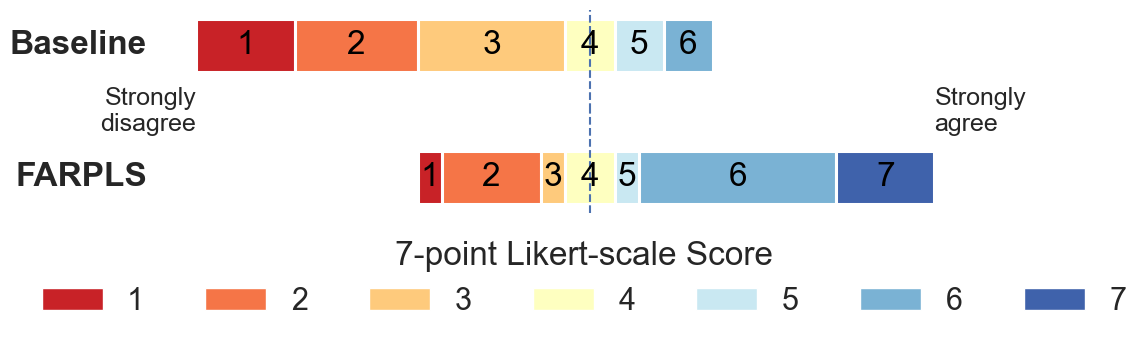

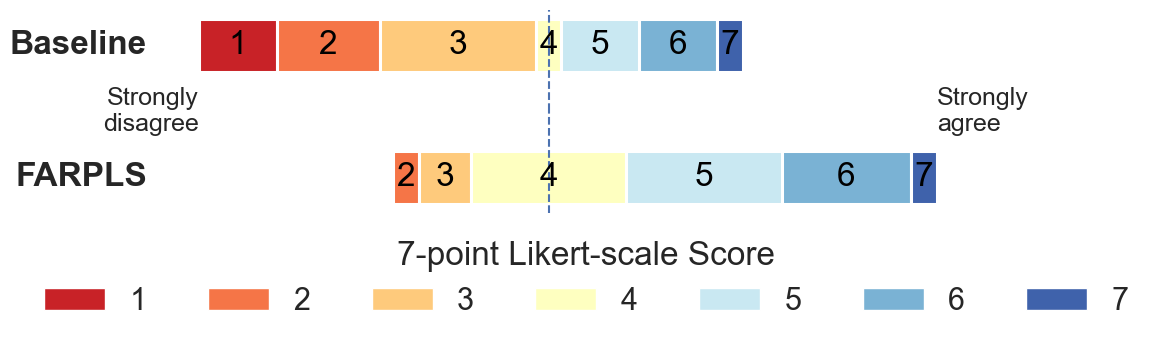

In [8]:
# 遍历每一列并绘图
for column in LIKERT_COLUMNS:
    if column == "User ID":
        continue
    plot_stacked_bar_for_column(column)

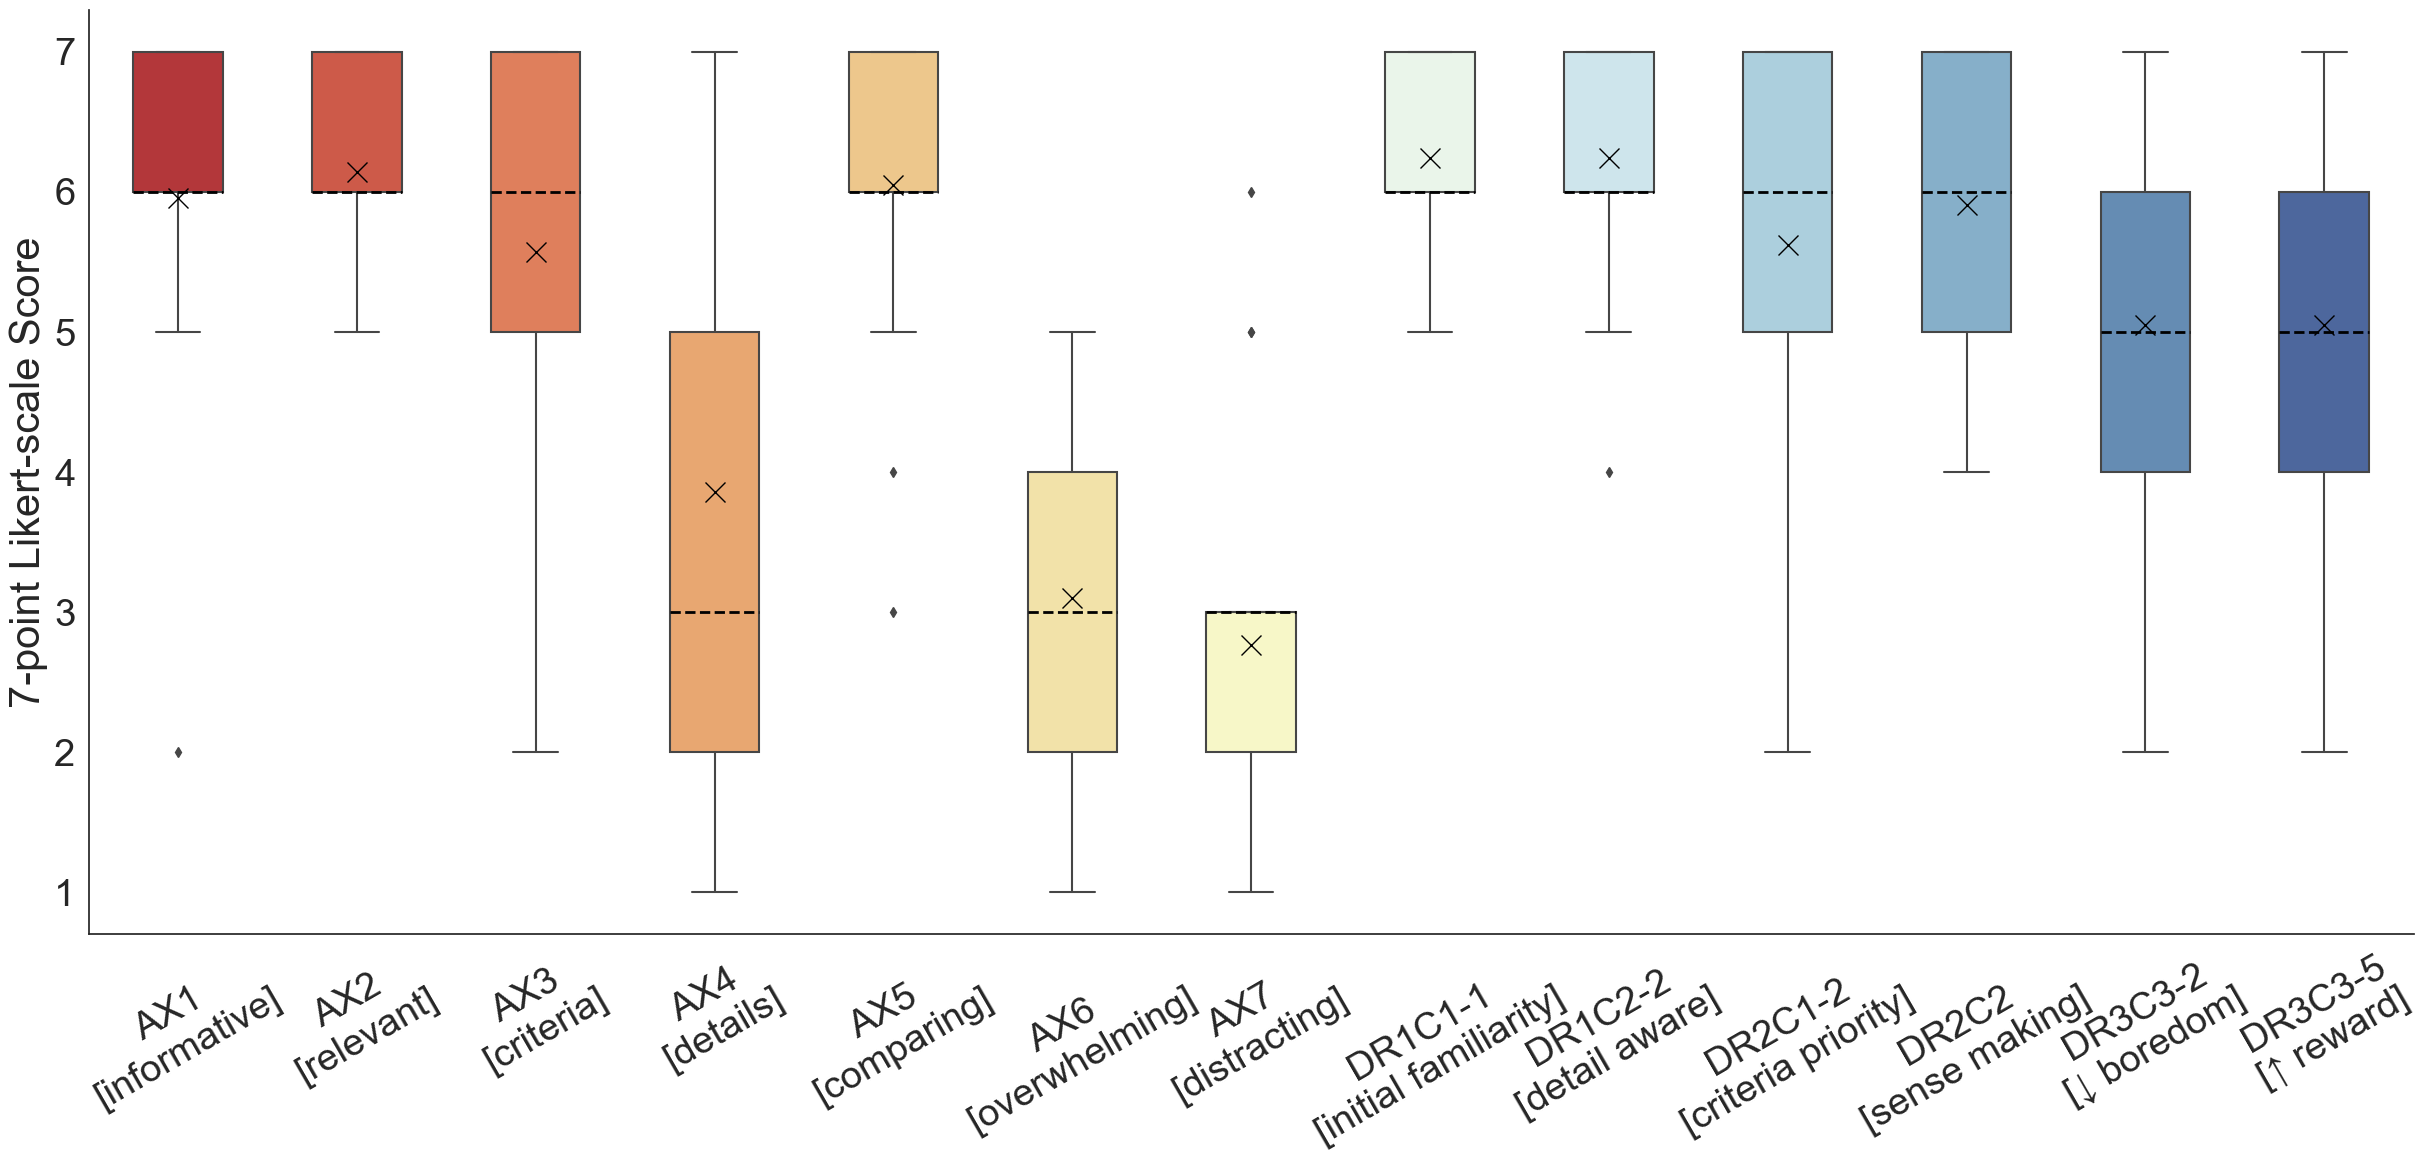

In [9]:
# plot additional results
sns.set_theme(style="white", font_scale=2.5)
additional_data = pd.melt(
    experiment_data,
    id_vars=["Group"],
    value_vars=QUALTRICS_ADDITIONAL_COLUMNS,
    var_name="Metric",
    value_name="7-point Likert-scale Score",
)
additional_data["Metric"] = additional_data["Metric"].map(QUALTRICS_ADDITIONAL_COLUMNS_MAP)

plt.figure(
    figsize=(
        4 + 2 * len(QUALTRICS_ADDITIONAL_COLUMNS),
        5.5 + 0.5 * len(QUALTRICS_ADDITIONAL_COLUMNS),
    )
)
ax = sns.boxplot(
    data=additional_data,
    x="Metric",
    y="7-point Likert-scale Score",
    palette="RdYlBu",
    width=0.5,
    showmeans=True,
    meanprops={
        "marker": "x",
        "markeredgecolor": "black",
        "markersize": "15",
    },
    medianprops={"color": "black", "linewidth": "2", "linestyle": "--"},
)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
ax.set_xlabel("")
plt.xticks(rotation=30)
plt.savefig(f"./fig/boxplot/Additional Results.pdf", bbox_inches="tight")
plt.show()